<div class="title">Practical Assignment: Dimensionality Reduction</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author">Ángela Fernández Pascual - Universidad Autónoma de Madrid</div>

---

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard).

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the KernelPCA class of `sklearn`.

This class will contain three public methods: `fit()`, `transform()` and `fit_transform()`.

# Implementation of KPCA

## Requirements

The objective of this assignment is to complete the class `KPCA` sketched below, which should contain at least the following methods.

---
```python
__init__(self, n_components, kernel, gamma)
```
* This is the construction method for the class, with the following parameters:
    * `n_components`: Reduced dimension.
    * `kernel`: `'linear'` or `'rbf'`.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$.
* This method should compute the projecting direction, storing the useful information in fields of the class.

---
```python
transform(self, X)
```
* This is the method that computes the projection, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* This method will used the stored information in the class for projecting new points.
---
```python
fit_transform(self, X)
```
* This method firstly fit the model, and latter apply it over the training data, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$.
* **NOTE**: This method can be implemented just calling the methods `fit` and `transform`; but also it can be computed more efficiently by theoretically computing the projection in this case. If this second approach is chosen, a brief explanation of why the implemented code is working will be required.

### Some recommendations:

* We will not pay attention to the dataset size when solving the eigenvector problem, the examples used will be simple ones. We recommend the use of `eigs` from `scipy` that computes only the first `k` eigenvalues and eigenvectors. It will be necessary to ensure that the eigenvectors are ordered in terms of the largest eigenvalues.
* The projection direction should be deterministic, so the eigenvectors finded should be flipped in terms of their sign to obtain always the same result.
* Data should be centered inside the method (so the data has zero mean, but the std remains the same), being careful to also center the new data points.
* Remember that the projection direction should have norm 1. This means that during the training the computed eigenvectors should be properly normalized and stored once normalized.

## Implementation

<div class="qst">

* Complete the `KPCA` class below, satisfying the described requirements.

</div>

In [4]:
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from sklearn.preprocessing import KernelCenterer
from scipy.sparse.linalg import eigs

class KPCA():
    """
        Kernel PCA.
    """
    def __init__(self, n_components, kernel, gamma=None):
        # Assignment of the hyper-parameters (complete).
        self.n_components = n_components
        if kernel == "rbf":
            self.kernel = lambda x,y: rbf_kernel(x, y, gamma)
        elif kernel == "linear":
            self.kernel = lambda x,y: linear_kernel(x, y)
        else:
            raise ValueError("Kernel must be ""linear"" or ""rbf"" ")
        self.gamma = gamma


    def fit(self, X):
        # Computation of the projection direction (complete).
        self.X_fit = X

        kc = KernelCenterer()
        kernel = self.kernel(X,X) #Sin centrar
        self.transformer = kc.fit(kernel)
        kcentered = self.transformer.transform(kernel)

        values, vectors = eigs(kcentered, k = self.n_components)
        eigenvalues = values.real
        eigenvectors = vectors.real

        normalizar = lambda autovector, autovalor: autovector/np.sqrt(autovalor)
        v = np.zeros(self.n_components)
        for i in range(self.n_components):
            v = normalizar(vectors, values)

        #Corregimos el signo para que sea determinista
        for i in range(self.n_components):
            maxval1 = max(eigenvectors[i,:], key=abs)
            signo1 = np.sign(maxval1)
            eigenvectors[i,:] = eigenvectors[i,:]*signo1
            maxval2 = max(v[:,i], key=abs)
            signo2 = np.sign(maxval2)
            v[:,i] = v[:,i]*signo2

        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
        self.eigenvectors_norm = v
        #Guardamos los vectores propios sin normalizar para la parte extra

    def transform(self, X):
        # Computation of the projected components (complete).
        # ...
        kernel = self.kernel(X, self.X_fit) #Sin centrar
        kcentered = self.transformer.transform(kernel)
        return self.eigenvectors_norm.T @ kcentered.T
        
    def fit_transform(self, X):
        # Computation of the projected components over X just after training with it (complete).
        # ...
        self.fit(X)
        return self.transform(X)

    def fit_transform2(self, X):
        return self.eigenvectors_norm @ self.eigenvalues

En un programa de aprendizaje automático, el método `fit_transform `consta siempre de dos partes, de una parte correspondiente al `fit` y otra correspondiente al `transform`. El `fit_transform`, toma como argumento la matriz de datos de entrenamiento X, llama al método `fit` para calcular los coeficientes necesarios para centrar el kernel a partir del cual halla los autovalores y autovectores necesarios para las proyecciones; luego, llama al método `transform` para calcular las proyecciones de los puntos en un espacio determinado. El método alternativo, en lugar de relizar esto, calcula las proyecciones directamente, para ello, hace el producto de la matriz de autovectores previamente normalizados, con los autovalores. Esto se puede observar con claridad en la diapositiva 36 del tema, donde se indica $V = \Phi^T \alpha$. Donde $\Phi$ hace referencia a los autovectores y $\alpha$ a los autovalores, ya que, además, estos vienen ordenados en orden descendiente por el módulo del autovalor.

# Experiments with KPCA

## Comparative with *scikit-learn*

The following cell generates the *blobs* dataset and depicts it.

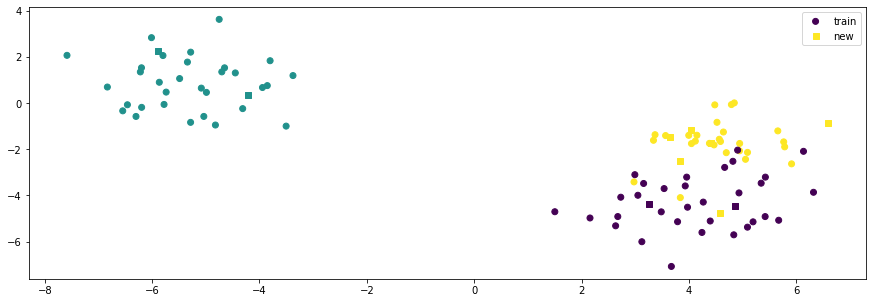

In [5]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=seed)
X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]

plt.scatter(X_train[:,0], X_train[:,1],c=y_train, label='train')
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, marker='s', label='new')
plt.legend()
plt.show()

---

<div class="qst">

* Train and transform a classical PCA model over the training data (`X_train`), using both the implemented `KPCA` class using a linear kernel and the `PCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

In [6]:
from sklearn.decomposition import PCA

kernel = 'linear'
n_components = 1

model_my = KPCA(n_components=n_components, kernel="linear")
model_sk = PCA(n_components=n_components)

# Training of the models (complete).
# ...
model_my.fit(X_train)
model_sk.fit(X_train)

# Comparative of the eigenvectors (complete).
# ...
print("Comparación de autovectores")
print("Autovectores de nuestro modelo:")
print(model_my.eigenvectors_norm)
print("Autovectores del modelo de sklearn:")
print(model_sk.components_)

Comparación de autovectores
Autovectores de nuestro modelo:
[[-0.00170185+0.j]
 [-0.00144365+0.j]
 [ 0.00315548+0.j]
 [-0.00089386+0.j]
 [-0.00149731+0.j]
 [ 0.00330584+0.j]
 [-0.00195384+0.j]
 [-0.00101385+0.j]
 [-0.00112589+0.j]
 [-0.00150643+0.j]
 [ 0.00316604+0.j]
 [-0.00124488+0.j]
 [ 0.00412394+0.j]
 [-0.00245382+0.j]
 [ 0.00272538+0.j]
 [ 0.00323974+0.j]
 [-0.00222184+0.j]
 [-0.00108122+0.j]
 [-0.00136759+0.j]
 [ 0.0025524 +0.j]
 [-0.00135725+0.j]
 [-0.00138989+0.j]
 [-0.0009797 +0.j]
 [ 0.00240797+0.j]
 [ 0.00310645+0.j]
 [ 0.00323024+0.j]
 [ 0.0028349 +0.j]
 [-0.00126455+0.j]
 [ 0.00339847+0.j]
 [-0.00121293+0.j]
 [-0.00204988+0.j]
 [-0.00226901+0.j]
 [-0.00157906+0.j]
 [-0.00179196+0.j]
 [-0.00203722+0.j]
 [ 0.00329657+0.j]
 [ 0.00310401+0.j]
 [-0.00159641+0.j]
 [-0.00124917+0.j]
 [-0.00213565+0.j]
 [ 0.00264391+0.j]
 [ 0.00227101+0.j]
 [ 0.00270032+0.j]
 [-0.00115289+0.j]
 [-0.00123387+0.j]
 [-0.00141198+0.j]
 [-0.00198297+0.j]
 [ 0.00249343+0.j]
 [-0.00164926+0.j]
 [ 0.0030

In [7]:
model_my = KPCA(n_components=n_components, kernel="linear")
model_sk = PCA(n_components=n_components)

# Training of the models (complete).
# ...
model_my.fit(X_train)
model_sk.fit(X_train)
# Comparative of the projections (complete).
# ...
print("-------------------------")
print("Comparación de las proyecciones")
print("Proyecciones de nuestro modelo:")
print(model_my.transform(X_new).real)
print("Proyecciones del modelo de sklearn:")
print(model_sk.transform(X_new).T)

-------------------------
Comparación de las proyecciones
Proyecciones de nuestro modelo:
[[-2.91306683 -2.56379231 -4.80706454 -4.59719367 -3.08472867 -2.33060981
   7.91074148  5.61290113 -4.47037834 -3.13577591]]
Proyecciones del modelo de sklearn:
[[-2.91306683 -2.56379231 -4.80706454 -4.59719367 -3.08472867 -2.33060981
   7.91074148  5.61290113 -4.47037834 -3.13577591]]


In [8]:
# Comparative of the projections using both fit_transform methods implemented by us
print("-------------------------")
print("Proyecciones del método fit_transform")
print(model_my.fit_transform(X_train).real)
print("Proyecciones del método fit_transform2")
print(model_my.fit_transform2(X_train).real)

-------------------------
Proyecciones del método fit_transform
[[-3.87773466 -3.28942576  7.18990337 -2.03669025 -3.41167465  7.53250091
  -4.45190229 -2.31009898 -2.56539133 -3.43247054  7.21394658 -2.83652056
   9.39657466 -5.5911429   6.20989159  7.38189493 -5.06255323 -2.46361313
  -3.11611177  5.81574736 -3.09254152 -3.16693215 -2.23227992  5.48665027
   7.07818093  7.3602487   6.45944704 -2.88132965  7.74355934 -2.76372017
  -4.67073999 -5.17003815 -3.59796212 -4.08305432 -4.64189293  7.51137545
   7.07261001 -3.6374931  -2.84629147 -4.86616211  6.02425983  5.17458119
   6.15279871 -2.62690346 -2.81143536 -3.21724775 -4.51827297  5.68137718
  -3.75790868  6.90822228  7.32406369  6.54041462  7.90839112 -4.46802509
   5.49885517  7.24475149 -2.35755082  6.4800305  -3.22115466 -2.76580919
  -4.47609753 -3.81934362 -1.60113438  4.44779142 -3.27499493 -4.87035613
  -5.7224499   7.85870166 -3.99148128 -3.92180685 -4.36809952 -5.17683922
  -2.75366314  8.23984978 -2.6550103   6.3815492

c:\Users\jonzo\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


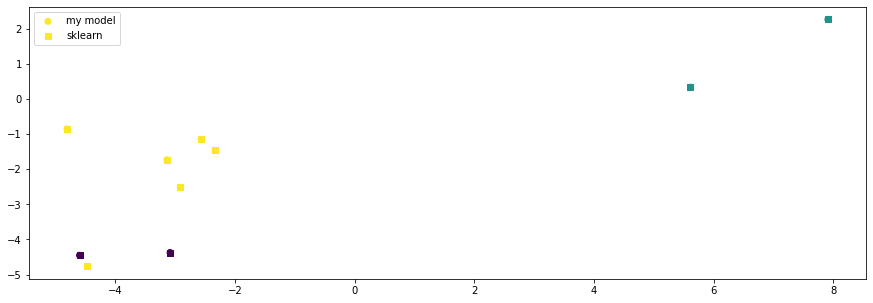

In [9]:
x_train_transf_my = model_my.transform(X_new)
x_train_transf_sk = model_sk.transform(X_new)

plt.scatter(x_train_transf_my[:], X_new[:,1], c=y_new, label='my model')
plt.scatter(x_train_transf_sk[:], X_new[:,1], c=y_new, marker='s', label='sklearn')
plt.legend()
plt.show()

- En primer lugar tenemos que hacer la comparativa entre los autovectores obtenidos tanto por el modelo PCA como por nuestro modelo KPCA. El modelo PCA, como se indica en la documentación, hace uso de la descomposición svd para hallar los valores y vectores propios. Al realizar la descomposición svd de la matriz de datos X, que es una matriz de dimensiones (90,2), la matriz diagonal asociada tendrá únicamente 2 autovalores, por ello, el autovector asociado tendrá dos elementos. Por otro lado, en nuestro modelo, tendremos un autovector de 90 elementos, uno pues hemos especificado `n_components=1`, lo cual implica tener únicamente vectores es una dirección, y 90 componentes porque es el tamaño de los datos de entrenamiento. 
- Luego, se han calculado las proyecciones de los puntos nuevos para el modelo de SKlearn y para nuestro modelo, y como se puede observar, se han obtenido los mismos 10 puntos.
- Por último, se han representado las proyecciones de los nuevos datos, para nuestro modelo y para el modelo de SKlearn. Como se puede observar, se obtienen las mismas representaciones en las tres figuras. 
- También se ha hecho una comparación adicional para las transformaciones de los datos de entrenamiento para nuestros dos métodos `fit_transform`, para comprobar que se obtiene el mismo resultado.
- Para la comparación de los autovalores y autovectores, se han representado únicamente la parte real y a veces se ha traspuesto el vector para observar con mayor claridad como los resultados quedan iguales. 

---

<div class="qst">

* Train and transform a Kernel PCA model using a RBF kernel over the training data (`X_train`), calling both the implemented `KPCA` class and the `KernelPCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

In [10]:
from sklearn.decomposition import KernelPCA

kernel = 'rbf'
n_components=1

# Model definition (complete).
model_my = KPCA(n_components=1, kernel=kernel)
model_sk = KernelPCA(kernel=kernel, fit_inverse_transform=True, n_components=n_components)

# Training of the models (complete).
# ...
model_my.fit(X_train)
model_sk.fit(X_train)

# Comparative of the eigenvectors (complete).
# ...
print("Comparación de los autovectores")
print("Autovectores de nuestro modelo")
print(model_my.eigenvectors.real.T)
print("Autovectores del modelo de sklearn")
print(model_sk.alphas_.T)

Comparación de los autovectores
Autovectores de nuestro modelo
[[ 0.06836262 -0.03380803  0.08755414 -0.09471101  0.0065262   0.09804105
   0.00759357  0.05201932 -0.04641738  0.06675903  0.11273815 -0.17778204
   0.04361036  0.04753199  0.11066928  0.03941534  0.05818873  0.02811017
  -0.19398104  0.07362361  0.02945271 -0.1749856  -0.1176125   0.08654216
   0.12963207  0.12790533  0.11788689  0.05709254  0.09579103  0.06054818
  -0.03091052  0.0579652   0.05182214 -0.10199366 -0.05534675  0.08791072
   0.13259448 -0.19072941 -0.04317653 -0.07229141  0.09326254  0.06760298
   0.08512147 -0.16018923 -0.17213752 -0.19491857  0.03659787  0.0743319
  -0.18544445  0.11687402  0.09313601  0.13123637  0.10427528 -0.11287215
   0.09158161  0.1040165   0.01018775  0.11182659 -0.19663195 -0.17126631
   0.06348271 -0.15229558  0.04147948  0.04583466 -0.19782225 -0.07343473
   0.01423732  0.10827886  0.04690041 -0.17427071 -0.11251528  0.05600139
   0.05154152  0.0604698   0.02701818  0.12680926 

In [11]:
# Comparative of the projections (complete).
# ...
print(model_my.transform(X_new).real)
print(model_sk.transform(X_new).T)

[[ 0.38556415  0.54331742  0.03487673 -0.16536335 -0.2276133   0.47658729
  -0.31491385 -0.36335373 -0.22042084  0.72367272]]
[[ 0.38556415  0.54331742  0.03487673 -0.16536335 -0.2276133   0.47658729
  -0.31491385 -0.36335373 -0.22042084  0.72367272]]


c:\Users\jonzo\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


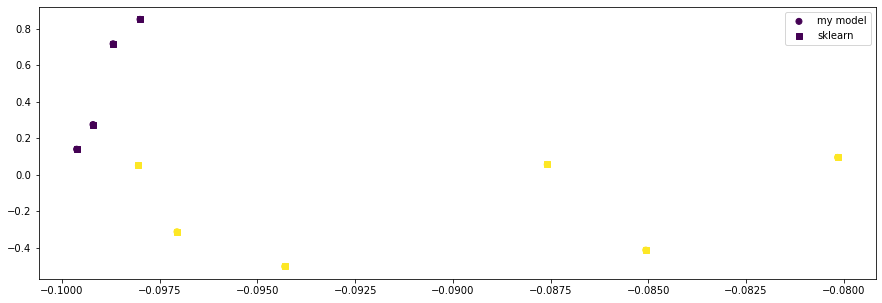

In [17]:
x_train_transf_my_rbf = model_my.transform(X_new)
x_train_transf_sk_rbf = model_sk.transform(X_new)

plt.scatter(x_train_transf_my_rbf[:], X_new[:,1], c=y_new, label='my model')
plt.scatter(x_train_transf_sk_rbf[:], X_new[:,1], c=y_new, marker='s', label='sklearn')
plt.legend()
plt.show()

- Como se puede observar, la comparación de autovalores es correcta para nuestros autovectores no normalizados y el atributo `alphas` de `KernelPCA`, excepto por el signo. Esto es porque nosotros hemos cambiado el signo a los autovalores normalizados y los no normalizados según el criterio que se ha mencionado previamente, mientras que en el método `KernelPCA` se puede observar que no se ha modificado el signo de estos.
- Luego, se han calculado las proyecciones de los nuevos datos, y han quedado muy parecidos iguales, tanto en valor numérico como en signo. 
- Por último, se ha hecho la representación gráfica de las proyecciones, y se puede ver como quedan en los mismos puntos.

## Comparing linear kernel against Gaussian kernel

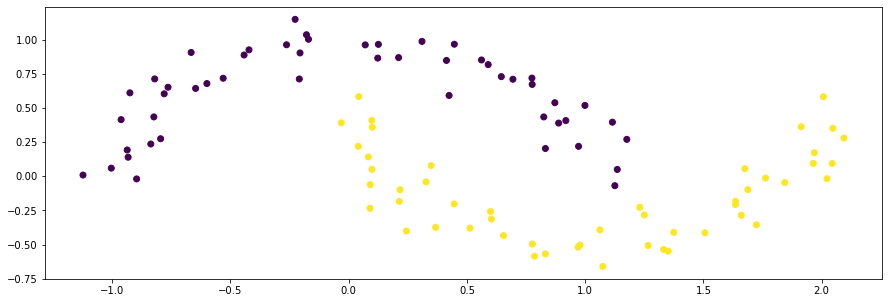

In [13]:
from sklearn.datasets import make_moons

X, y = make_moons(noise=1e-1, random_state=seed)

plt.scatter(X[:,0], X[:,1],c=y)

<div class="qst">

* Using the implemented class `KPCA` compare the result of transforming the above dataset using a linear kernel and an RBF one (looking for an appropriated hyperparameter `gamma` value).
* Is there some model able to properly project the classes separately?
</div>

In [18]:
n_components=1

model_linear = KPCA(n_components=n_components, kernel='linear')
model_rbf = KPCA(n_components=n_components, kernel='rbf')

X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]

# Training of the models (complete).
# ...
model_linear.fit(X_train)
model_rbf.fit(X_train)

# Comparative of the projections (complete).
# ...
print("Comparación de las proyecciones en ambos modelos")
print("Proyecciones del modelo lineal")
print(model_linear.transform(X_new).real)
print("Proyecciones del modelo rbf")
print(model_rbf.transform(X_new).real)

Comparación de las proyecciones en ambos modelos
Proyecciones del modelo lineal
[[-1.25683752 -1.13956394  0.66932184 -1.34663233  1.1632587  -0.33722133
   1.1449425  -0.13970478  1.42698574  0.25444918]]
Proyecciones del modelo rbf
[[ 0.61480897  0.67941331 -0.50264202  0.56593733 -0.64377067  0.22700084
  -0.65694446  0.17880896 -0.61600925 -0.26377064]]


Como se puede observar, las proyecciones son diferentes para ambos modelos. El modelo lineal, al estar basado en productos entre componentes, dará unas proyecciones más distanciadas entre sí; mientras que el modelo rbf, al estar basado en la exponencial de la norma euclídea de las distintas componentes, será más suave y las proyecciones estarán más centradas.